In [1]:
import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader

torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - Hellinger - 1to1

### Training

In [49]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))    # changed to take as input the parameters of the tgauss
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

    def forward(self, params):

        output = self.network(params)
        
        weights = torch.ones(output[:, 0].shape)
        mus = torch.exp(output[:, 1:self.xdim+1])                                                      
        covs = torch.exp(output[:, self.xdim+1:]) + EPS

        return weights, mus, covs

#### Generation of a dataset of truncated Gaussians

In [51]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix


def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for truncated Gaussians """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

In [61]:
# half of the samples are close to zero

niter = 100000 # number of gaussian mixtures seen during training

ncomp = 1
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5

trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

In [62]:
train_dataloader = DataLoader(trunc_gauss, batch_size=64, shuffle=True) # increased batch size, added shuffle

#### Minibatch loss function

In [63]:
EPS = 10**(-10)
#import math 

def hellinger_distance(m1,s1,m2,s2):
    """ m1, s1 are the mean and the standard deviation of the truncated gaussian
    m2, s2 are the mean and the standard deviation of the gaussian """
    
    den1 = torch.sqrt(s1*s1+s2*s2)

    B = 0.5*(m1*s2*s2+m2*s1*s1)/(s1*s2*den1+EPS)
    C = m1/(s1*torch.sqrt(torch.tensor(2.))+EPS)
    D = 0.25*(-m1*m1*s2*s2-m2*m2*s1*s1+(m1*s2*s2+m2*s1*s1)**2/(s1*s1+s2*s2+EPS))/(s1*s1*s2*s2+EPS)
    den2 = torch.sqrt(1+torch.erf(C))
    den = den1*den2+EPS
    num = -torch.sqrt(s1*s2)*(1+torch.erf(B))*torch.exp(D)+den
    L = num/den
    if L < 0 or L > 1:
      #print('io = ', m1,s1,m2,s2)
      #print(f'sqrt(s1*s2)={math.sqrt(s1*s2)}, erf(B)={torch.erf(B)}, erf(C)={torch.erf(C)}')
      #print(f'B={B}, C={C}, D={D}, den={den}, num={num}')
      #print(f'L={L}')
      L = torch.tensor(1.)
    
    return L

In [64]:
# parameters of the truncated gaussian
mu1 = torch.tensor(1.)
s1 = torch.tensor(1.)
#parameters of the gaussian
mu2 = torch.tensor(5.0)
s2 = torch.tensor(1000)

hellinger_distance(mu1, s1, mu2, s2)

tensor(0.9629)

In [65]:
def loss_function_minibatch(trunc, new_pi, new_mu, new_sigma):
    total_loss = 0
    for idx, params in enumerate(trunc):
        loss = 100*hellinger_distance(params[1], torch.sqrt(params[2]), new_mu[idx][0], torch.sqrt(new_sigma[idx][0])) 
        if loss.isnan():
            print('NaN loss for', params[1], torch.sqrt(params[2]), new_mu[idx][0], torch.sqrt(new_sigma[idx][0]))
            raise
        total_loss += loss
    return (total_loss + torch.linalg.norm(new_sigma) + torch.linalg.norm(new_mu))/len(trunc)

def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):
    
    model.train()
    counter = 0
    losses = []
    
    for bach_idx, tgauss_batch in enumerate(training_dataloader):

        pi_new, mu_new, sigma_new = model(tgauss_batch)
        if torch.any(mu_new.isnan()) or torch.any(sigma_new.isnan()):
            print('Model has generated Nan instances')
        
        loss = loss_fn(tgauss_batch, pi_new, mu_new, sigma_new)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print information
        if counter % 500 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
            losses.append(loss)
        
        if counter % 500 == 0:
            print('Generated', tgauss_batch[-1][1:])
            print('Predicted', mu_new[-1], sigma_new[-1])
            
        counter += 1

    return losses


In [66]:
epochs = 1
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)              # added weight_decay

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-hellinger-1ep-1to1.pth')


Epoch 1
-------------------------------
loss: 57.683292
Generated tensor([14.4112,  0.2005])
Predicted tensor([0.8466], grad_fn=<SelectBackward0>) tensor([0.9206], grad_fn=<SelectBackward0>)
loss: 27.473682
Generated tensor([0.7761, 0.2817])
Predicted tensor([0.7067], grad_fn=<SelectBackward0>) tensor([0.2102], grad_fn=<SelectBackward0>)
loss: 9.229205
Generated tensor([0.4724, 0.0470])
Predicted tensor([0.4775], grad_fn=<SelectBackward0>) tensor([0.0503], grad_fn=<SelectBackward0>)
loss: 11.521162
Generated tensor([8.5279e+00, 2.5500e-03])
Predicted tensor([8.2944], grad_fn=<SelectBackward0>) tensor([0.7495], grad_fn=<SelectBackward0>)
Done!


In [67]:
epochs = 10
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)              # added weight_decay

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-hellinger-10ep-1to1.pth')


Epoch 1
-------------------------------
loss: 60.498436
Generated tensor([14.5134,  4.2558])
Predicted tensor([0.9406], grad_fn=<SelectBackward0>) tensor([1.2166], grad_fn=<SelectBackward0>)
loss: 27.120537
Generated tensor([18.6028,  0.0589])
Predicted tensor([22.2226], grad_fn=<SelectBackward0>) tensor([12.2226], grad_fn=<SelectBackward0>)
loss: 10.031477
Generated tensor([0.4694, 0.0646])
Predicted tensor([0.5285], grad_fn=<SelectBackward0>) tensor([0.0651], grad_fn=<SelectBackward0>)
loss: 9.114628
Generated tensor([0.2314, 0.0249])
Predicted tensor([0.3427], grad_fn=<SelectBackward0>) tensor([0.0388], grad_fn=<SelectBackward0>)

Epoch 2
-------------------------------
loss: 7.733397
Generated tensor([0.5843, 0.2265])
Predicted tensor([0.6723], grad_fn=<SelectBackward0>) tensor([0.0715], grad_fn=<SelectBackward0>)
loss: 9.363803
Generated tensor([8.7945, 0.3986])
Predicted tensor([8.7630], grad_fn=<SelectBackward0>) tensor([0.4817], grad_fn=<SelectBackward0>)
loss: 8.826249
Genera

# Test

#### 1 Epoch

In [68]:
ncomp = 1
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-hellinger-1ep-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_27944\3029842331.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-hellinger-1ep-1to1.pt

In [69]:
test_means = []
test_covs = []
pred_means = []
pred_covs = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([torch.tensor([1.]), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,3)

    pi_pred, mu_pred, sigma_pred = model(params)
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)

print('Test params:', test_means, test_covs)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: [tensor([[1.1817]]), tensor([[1.7610]]), tensor([[1.1092]]), tensor([[1.4186]]), tensor([[1.2848]]), tensor([[0.7593]]), tensor([[1.1127]]), tensor([[1.7537]]), tensor([[0.8766]]), tensor([[0.5241]])] [tensor([[13.5990]]), tensor([[10.7563]]), tensor([[4.4925]]), tensor([[1.8790]]), tensor([[0.7932]]), tensor([[5.3051]]), tensor([[4.3342]]), tensor([[1.8806]]), tensor([[3.8131]]), tensor([[7.8880]])]
Pred params: tensor([1.]) tensor([[2.4065]], grad_fn=<ExpBackward0>) tensor([[2.0682]], grad_fn=<AddBackward0>)


In [70]:
import libSOGA

soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[i])], [np.array(test_covs[i])]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_means.append(new_soga_dist.gm.mu[0])
    soga_covs.append(new_soga_dist.gm.sigma[0])

soga_means, soga_covs

([array([[3.41533767]]),
  array([[3.36926058]]),
  array([[2.16315892]]),
  array([[1.79536695]]),
  array([[1.42046324]]),
  array([[2.14249863]]),
  array([[2.13619679]]),
  array([[2.02218245]]),
  array([[1.92280669]]),
  array([[2.44236721]])],
 [array([[5.97047704]]),
  array([[5.33780898]]),
  array([[2.21264096]]),
  array([[1.20257877]]),
  array([[0.60055786]]),
  array([[2.34153429]]),
  array([[2.1479285]]),
  array([[1.33764876]]),
  array([[1.80151187]]),
  array([[3.20292586]])])

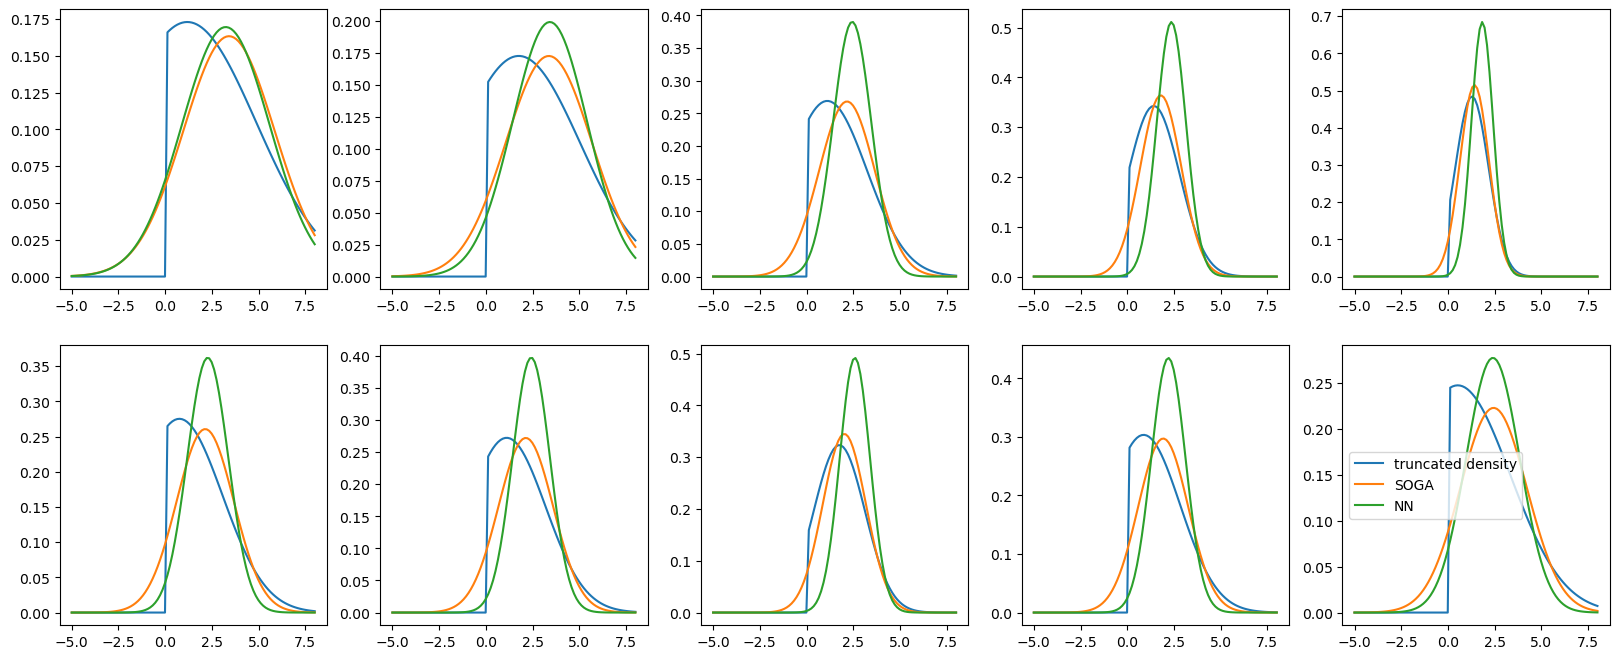

In [71]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
    y_soga = norm.pdf(x, soga_means[i], np.sqrt(soga_covs[i])).reshape(x.shape)
    y_nn = norm.pdf(x, pred_means[i].detach().numpy(), np.sqrt(pred_covs[i].detach().numpy())).reshape(x.shape)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('hellinger.pdf')

#### 10 Epoch

In [72]:
ncomp = 1
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-hellinger-10ep-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_27944\4078648392.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-hellinger-10ep-1to1.p

In [73]:
test_means = []
test_covs = []
pred_means = []
pred_covs = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([torch.tensor([1.]), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,3)

    pi_pred, mu_pred, sigma_pred = model(params)
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)

print('Test params:', test_means, test_covs)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: [tensor([[0.5408]]), tensor([[0.7260]]), tensor([[0.9878]]), tensor([[1.0896]]), tensor([[1.3925]]), tensor([[1.0487]]), tensor([[0.7875]]), tensor([[0.0629]]), tensor([[1.9603]]), tensor([[0.0181]])] [tensor([[8.8790]]), tensor([[11.3071]]), tensor([[1.8231]]), tensor([[0.1905]]), tensor([[2.4191]]), tensor([[2.6778]]), tensor([[3.8702]]), tensor([[4.1737]]), tensor([[0.0033]]), tensor([[7.0388]])]
Pred params: tensor([1.]) tensor([[2.0456]], grad_fn=<ExpBackward0>) tensor([[2.2032]], grad_fn=<AddBackward0>)


In [74]:
import libSOGA

soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[i])], [np.array(test_covs[i])]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_means.append(new_soga_dist.gm.mu[0])
    soga_covs.append(new_soga_dist.gm.sigma[0])

soga_means, soga_covs

([array([[2.58506664]]),
  array([[2.96451513]]),
  array([[1.52466178]]),
  array([[1.09741036]]),
  array([[1.90265886]]),
  array([[1.76788833]]),
  array([[1.89256787]]),
  array([[1.6531148]]),
  array([[1.96026397]]),
  array([[2.12343186]])],
 [array([[3.59445208]]),
  array([[4.67099534]]),
  array([[1.00459175]]),
  array([[0.18199882]]),
  array([[1.44850931]]),
  array([[1.40625592]]),
  array([[1.77879898]]),
  array([[1.5448786]]),
  array([[0.00328209]]),
  array([[2.56824036]])])

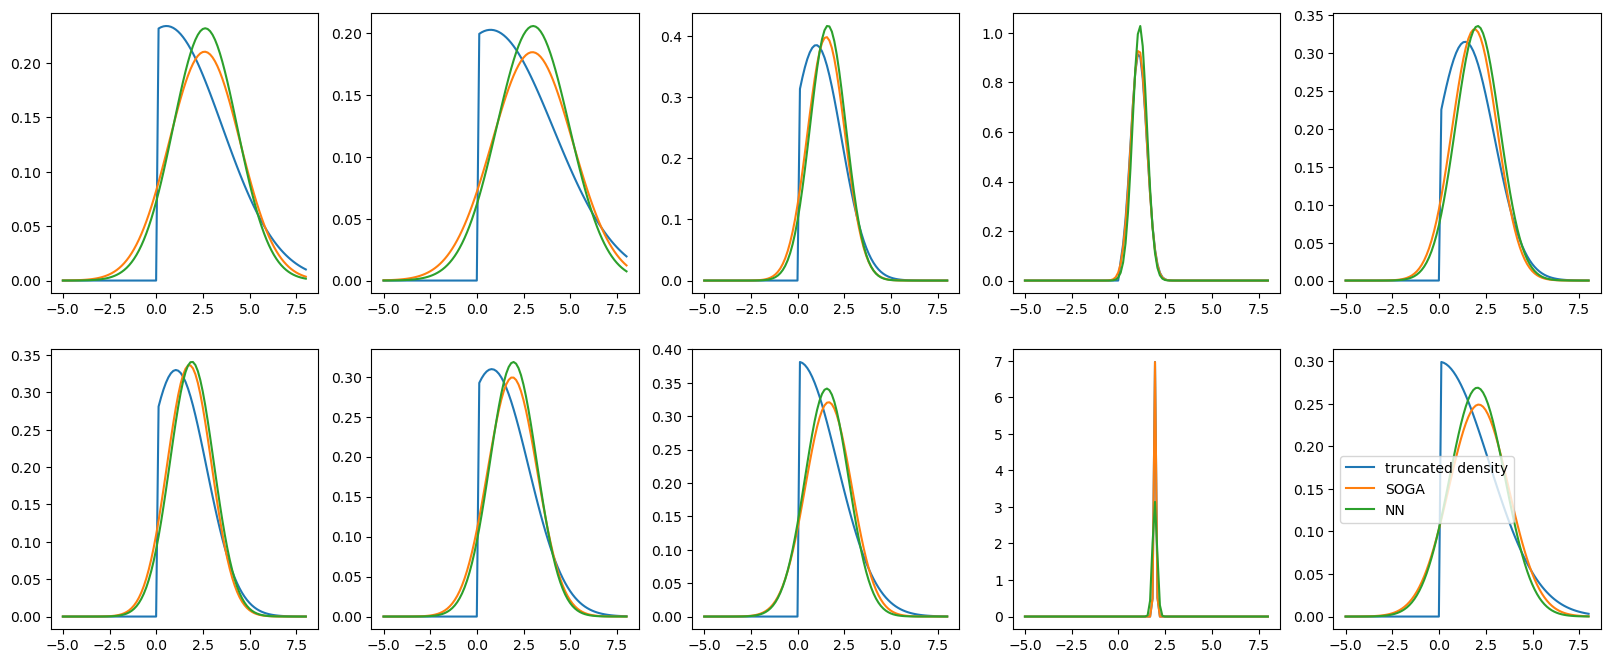

In [75]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
    y_soga = norm.pdf(x, soga_means[i], np.sqrt(soga_covs[i])).reshape(x.shape)
    y_nn = norm.pdf(x, pred_means[i].detach().numpy(), np.sqrt(pred_covs[i].detach().numpy())).reshape(x.shape)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('hellinger.pdf')